### Decision Tree (DecisionTree.ipynb)
Train a Decision Tree classifier, selecting a rule for when it is time to stop branching to
avoid overfitting.

Goal: See how a ChoiceMaker performs when applied to a novel area. Having the lowest error 
compared to naive methods would be great.

Comparison: We compare against a naive way of making a decision tree algorithm
private, as well as another method described in a sketchy paper. I implemented
everything.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Improvement 1: figure out a way to make epsilon equal to 1.0 always.
Improvement 2: simplify the error computations.


In [2]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections

In [3]:
class DB:
    def __init__(self, X, y, X_test, y_test, epsilon=1, depth=0, max_depth=0):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = X
        self.y = y
        self.X_test = X_test
        self.y_test = y_test
        self.depth = depth
        self.max_depth = max_depth
        #branching_factor?
        
class DBMetas:
    def __init__(self):
        self.sensitivities = collections.OrderedDict((
        ('nrow', 1), ('ncol', 0), ('eps', 0), ('depth', 0), ('C', 0), ('bf', 0), ('t', 0)
                                                    ))
    
    def __call__(self, dataset):
        att_sizes = np.array([len(dataset.X[c].cat.categories) for c in dataset.X])
        return collections.OrderedDict((
                ('nrow', dataset.X.shape[0]), 
                ('ncol', dataset.X.shape[1]),
                ('eps', dataset.epsilon),
                ('depth', dataset.depth),
                ('C', len(dataset.y.cat.categories)),
                ('bf', att_sizes.mean()),
                ('t', att_sizes.max()) ))
def entropy(y):
    arr = pd.value_counts(y)
    arr = arr[arr > 0]
    arr = arr/arr.sum()
    return (-np.log2(arr) * arr).sum()

In [237]:
class TreePart:
    def __init__(self, splits=5):
        self.splits=splits
        self.kf = model_selection.KFold(splits)
        self.lo = model_selection.LeaveOneOut()
    def get_expected_correct(self, y, epsilon):
        if len(y) == 0:
            return 0
        tot_correct = 0
        if len(y) < self.splits:
            gen = self.lo.split(y)
        else:
            gen = self.kf.split(y)
        for train_idx, test_idx in gen:
            hist = pd.value_counts(y.iloc[train_idx])
            noisy_hist = dp.hist_noiser(hist, epsilon)
            pred = noisy_hist.idxmax()
            tot_correct += (y.iloc[test_idx] == pred).sum()
        return tot_correct / len(y)
    
"""The leaf algorithm"""
class Leaf(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        return 1.0-self.get_expected_correct(db.y, db.epsilon)
    def run(self, db):
        print('leaf running')
        frequencies = pd.value_counts(db.y)
        noisy_freqs = dp.hist_noiser(frequencies, db.epsilon)
        return np.repeat(noisy_freqs.idxmax(), db.y_test.size)
    
"""The branch algorithm (splits the data)"""
class Split(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        corrects = []
        probs = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            correct = 0
            tot_ent = 0
            for cat in cats:
                leaf_correct = self.get_expected_correct(db.y[x == cat], db.epsilon)
                correct += leaf_correct * (x == cat).sum()
                ent = entropy(db.y[x == cat])
                tot_ent += ent*(x==cat).sum()
            correct /= len(db.y)
            corrects.append(correct)
            probs.append(tot_ent)
        C = np.array(corrects)
        probs = np.array(probs)
        probs -= probs.min()
        D = np.exp(-probs*db.epsilon/13) #13 is an upper bound on the sensitivity of entropy, log_2 |X|
        probs = D/D.sum()
        return 1-probs.dot(C)
    def run(self, db):
        print('branch run')
        return None
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [5]:
split = Split()
leaf = Leaf()
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [234]:
"""Private Decision Tree algorithm"""
class PDTree:
    def __init__(self):
        pass
    
    def entropy(self, y):
        arr = pd.value_counts(y)
        arr = arr[arr > 0]
        arr = arr/arr.sum()
        return (-np.log2(arr) * arr).sum()
    
    def decision_helper(self, db, cm):
        action = cm.choose(db)
        if db.depth == db.max_depth:
            print('max depth reached')
            action = leaf.run(db)
        if action is not None:
            return action
        utils = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            cur_ent = 0
            for cat in cats:
                ent = self.entropy(db.y[x == cat])
                cur_ent += ent * (x == cat).sum()
            #cur_ent /= len(db.y)
            utils.append(-cur_ent)
        best_idx = dp.exp_mech(utils, db.epsilon, 13) #Change sensitivity
        col_name = db.X.columns[best_idx]
        new_cols = db.X.columns[db.X.columns != col_name]
        splitX = db.X[col_name]
        splitX_test = db.X_test[col_name]
        preds = np.repeat(db.y.cat.categories[0], len(db.y_test))
        for att in splitX_test.unique():
            train_split = db.X.loc[splitX == att, new_cols]
            y_split = db.y[splitX == att]
            test_split_loc = db.X_test[col_name] == att 
            test_split = db.X_test.loc[test_split_loc, new_cols]
            test_split_y = db.y_test.loc[test_split_loc]
            if(test_split_y.size > 0):
                db_new = DB(train_split, y_split, test_split, test_split_y, db.epsilon, db.depth+1, db.max_depth)
                preds[test_split_loc] = self.decision_helper(db_new, cm)
        return preds
    
    def fit_and_predict(self, data, cm):
        budget = data.epsilon / data.X.shape[1]
        data.epsilon = budget
        return self.decision_helper(data, cm)

In [7]:
class CoefCM:
    def __init__(self, tree_algs, coefs, const):
        self.m = DBMetas()
        self.tree_algs = tree_algs
        self.coefs = np.array(coefs)
        self.const = const
    def choose(self, data, ratio=0.3):
        budget = data.epsilon*ratio
        metas = self.m(data)
        metas['nrow'] += dp.laplacian(budget, sensitivity=1)[0]
        data.epsilon -= budget
        metas = np.array(list(metas.values()))
        metas = np.log(np.maximum(metas, 1))
        if metas.dot(self.coefs) <= self.const:
            return self.tree_algs['leaf'].run(data)
        else:
            return self.tree_algs['split'].run(data)
fried_cm = CoefCM(tree_algs, [1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [43]:
adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))

In [44]:
leaf = Leaf()
split = Split()

In [ ]:
class null_cm:
    def __init__(self):
        pass
    def choose(self, db):
        if db.depth < db.max_depth:
            return split.run(db)
        else:
            return leaf.run(db)

### Experiments

In [56]:
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 4): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [46]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [58]:
prng=np.random.RandomState(12345)
eps_vals = np.arange(0.1, 1.0, 0.3)*10
def get_test(db, prng):
    dbs = []
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_train_dbs(db, e, prng))
    return dbs
data_train = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [68]:
"""
def get_cm(db):
    eps_vals = np.arange(0.1, 1.0, 0.1)
    info = [get_train_dbs(db, x, prng) for x in eps_vals]
    print(len(info))
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return (DTChoice(X, DBMetas(), tree_algs, regrets=regrets), datas)

from multiprocessing import Pool
p = Pool(6)
out = p.map(get_cm, [nurs, default, loan, adult, lending])
"""

'\ndef get_cm(db):\n    eps_vals = np.arange(0.1, 1.0, 0.1)\n    info = [get_train_dbs(db, x, prng) for x in eps_vals]\n    print(len(info))\n    regrets, X, datas = zip(*info)\n    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)\n    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)\n    return (DTChoice(X, DBMetas(), tree_algs, regrets=regrets), datas)\n\nfrom multiprocessing import Pool\np = Pool(6)\nout = p.map(get_cm, [nurs, default, loan, adult, lending])\n'

In [125]:
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

out = [get_cm(o) for o in data_train]

In [243]:
pickle.dump([cm.X for cm in out], open('decision_tree_metadata/data.pkl', 'wb'))

In [247]:
pickle.dump([cm.regrets for cm in out], open('decision_tree_metadata/regrets.pkl', 'wb'))

In [249]:
pickle.dump(data_train, open('decision_tree_metadata/training_dbs.pkl', 'wb'))

In [250]:
mfs = pickle.load(open('decision_tree_metadata/data.pkl', 'rb'))
regs = pickle.load(open('decision_tree_metadata/regrets.pkl', 'rb'))
tdbs = pickle.load(open('decision_tree_metadata/training_dbs.pkl', 'rb'))

5

In [253]:
DTChoice(mfs[0], DBMetas(), tree_algs, regrets=regs[0])

In [126]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [127]:
def get_results(dbs, cm, cm2):
    dt = PDTree()
    budgets = [x.epsilon for x in dbs]
    L = []
    for t in dbs:
        print('Start1')
        L.append( dt.fit_and_predict(t, null_cm()) )
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L2 = []
    for t in dbs:
        print('Start2')
        L2.append(dt.fit_and_predict(t, cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L3 = []
    for t in dbs:
        print('Start3')
        L3.append(dt.fit_and_predict(t, cm2))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M2 = np.array([(L2[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M3 = np.array([(L3[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    return (M, M2, M3)

In [198]:
prng=np.random.RandomState(12345)
[get_test_dbs(db, 2.0, prng) for db in [nurs, default, loan, adult, lending]]

### Experiment 0

In [128]:
big_cm0 = combine_cms(out[1:])

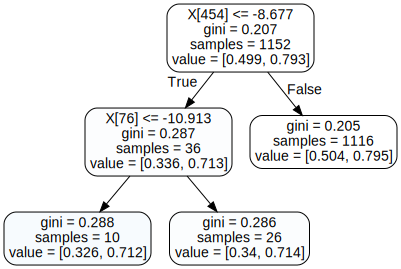

In [211]:
dot_data = export_graphviz(out[0].model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [210]:
out[0].model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
out[0].retrain_model()

In [129]:
big_cm0.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
big_cm0.retrain_model()

In [230]:
D = get_test_dbs(default, 2.0, prng)

In [232]:
D.max_depth=2

In [238]:
nurs1, nurs2, nurs3 = get_results([get_test_dbs(nurs, 2.0, prng)], out[0], fried_cm)

Start1
0
1
2
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
4
max depth reached
2
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
2
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
2
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
2
3
4
max depth reached
4
max depth reached
4
max depth reached
4
max depth reached
3
4
max depth reached
4
max depth reached
4
max depth reached
1
2
3
4
max depth reached
4
max depth reached
4
m

KeyboardInterrupt: 

Process ForkPoolWorker-66:
KeyboardInterrupt
Process ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/jacob/anaconda3/lib/pytho

In [229]:
dt.fit_and_predict(D, out[0])

array([1, 0, 1, ..., 0, 1, 0])

In [222]:
(nurs1.mean(), nurs2.mean(), nurs3.mean())

(0.60426382411725521, 0.34843437708194536, 0.33710859427048634)

### Experiment 1

In [173]:
big_cm = combine_cms(out[:1] + out[2:])

In [174]:
big_cm.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm.retrain_model()

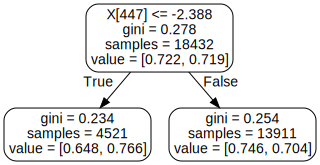

In [175]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [179]:
coefs0 = big_cm.trans[447-7].coefs
coefs0

[-1, 0, 1, 0, -1, 1, 1]

In [180]:
test_cm1 = CoefCM(tree_algs, coefs0, -2.388)

In [181]:
defaults1, defaults2, defaults3 = get_results(data_train[1], test_cm1, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [182]:
(defaults1.mean(), defaults2.mean(), defaults3.mean())

(0.64388076957089735, 0.77747889855294039, 0.65413755040832311)

### Experiment 2

In [183]:
big_cm2 = combine_cms(out[:2] + out[3:])

In [78]:
big_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm2.retrain_model()

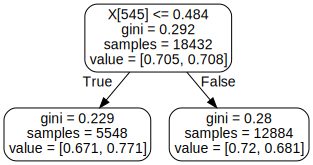

In [79]:
dot_data = export_graphviz(big_cm2.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [184]:
coefs = big_cm2.trans[545-7].coefs
coefs

[-1, 1, -1, 0, 1, 1, 0]

In [185]:
test_cm2 = CoefCM(tree_algs, coefs, 0.484)

In [186]:
loans1, loans2, loans3 = get_results(data_train[2], test_cm2, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [187]:
(loans1.mean(), loans2.mean(), loans3.mean())

(0.71281690961268562, 0.90724068649198963, 0.77666952792189092)

### Experiment 3

In [188]:
big_cm3 = combine_cms(out[:3] + out[4:])

In [189]:
big_cm3.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm3.retrain_model()

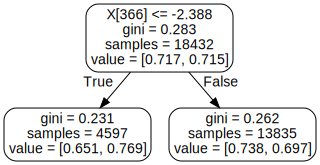

In [190]:
dot_data = export_graphviz(big_cm3.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [192]:
coefs = big_cm3.trans[366-7].coefs
coefs

[-1, 0, 0, 0, -1, 1, 1]

In [194]:
test_cm3 = CoefCM(tree_algs, coefs, -2.388)

In [195]:
adults1, adults2, adults3 = get_results(data_train[3], test_cm3, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [196]:
(adults1.mean(), adults2.mean(), adults3.mean())

(0.73641029479602826, 0.75530363748071583, 0.67664697966414922)

### Experiment 4

In [199]:
big_cm4 = combine_cms(out[:4] + out[5:])

In [200]:
big_cm4.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm4.retrain_model()

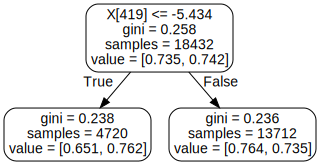

In [202]:
dot_data = export_graphviz(big_cm4.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [203]:
coefs = big_cm4.trans[419-7].coefs
coefs

[-1, 0, 1, -1, -1, 1, 0]

In [204]:
test_cm4 = CoefCM(tree_algs, coefs, -5.434)

In [205]:
lendings1, lendings2, lendings3 = get_results(data_train[3], test_cm4, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [206]:
(lendings1.mean(), lendings2.mean(), lendings3.mean())

(0.75084534963292826, 0.75530363748071583, 0.67419395834546814)

In [249]:
lendings1

array([ 0.79485531,  0.75940237,  0.78988561,  0.70393901,  0.75174014,
        0.76889849,  0.66328012,  0.7494877 ,  0.7761194 ])

In [280]:
alg1_error = 1-np.array([nurs1, defaults1, loans1, adults1, lendings1])

In [281]:
alg2_error = 1-np.array([nurs2, defaults2, loans2, adults2, lendings2])

In [282]:
alg3_error = 1-np.array([nurs3, defaults3, loans3, adults3, lendings3])

In [283]:
#best = np.min([alg1_error, alg2_error, alg3_error], axis=0)
#avg_regret1 = (alg1_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret2 = (alg2_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret3 = (alg3_error-best).reshape((3,-1)).mean(axis=0)

In [284]:
alg1_error = alg1_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg2_error = alg2_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg3_error = alg3_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))

In [285]:
alg1_error = alg1_error.mean(axis=1)
alg2_error = alg2_error.mean(axis=1)
alg3_error = alg3_error.mean(axis=1)

In [293]:
juxtaposed_alg_perfs = np.array([alg1_error, alg3_error, alg2_error]).T.flatten()

In [294]:
x_pos = np.array([4*x + y for x in [0,1,2] for y in [0,1,2]])

In [295]:
colors = ['red', 'blue', 'green']*3

In [296]:
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green']]

<Container object of 9 artists>

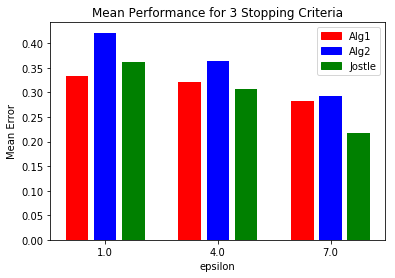

In [297]:
fig, axis = plt.subplots()
axis.set_xticks([1,5,9])
axis.set_xticklabels(['1.0', '4.0', '7.0'])
axis.set_xlabel('epsilon')
axis.set_ylabel('Mean Error')
axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)

In [ ]:
fig, axis = plt.subplots()
for a in 